In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import re


In [42]:
# Function to plot a bar chart from a dictionary
def bar_chart(data_dict, title='', xlabel='', ylabel=''):
    plt.figure(figsize=(8, 6))
    plt.bar(data_dict.keys(), data_dict.values(), color='steelblue')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(list(data_dict.keys()))
    plt.show()

def preview_df(df, name="", num_rows=3):
    print( "-" * 40 )
    print( f"DataFrame Preview: {name}" )
    print( f"DataFrame Shape: {df.shape}" )
    print( f"DataFrame Columns: {df.columns.tolist()}" )
    display(df.sample(num_rows))


# Carga de Datos

In [43]:

data_reviews = pd.read_csv('../data/olist_order_reviews_dataset.csv')
data_orders = pd.read_csv('../data/olist_orders_dataset.csv')
data_customers = pd.read_csv('../data/olist_customers_dataset.csv')
data_order_items = pd.read_csv('../data/olist_order_items_dataset.csv')
data_sellers = pd.read_csv('../data/olist_sellers_dataset.csv')
data_products = pd.read_csv('../data/olist_products_dataset.csv')
data_categories = pd.read_csv('../data/product_category_name_translation.csv')
data_geolocation = pd.read_csv('../data/olist_geolocation_dataset.csv')
data_payments = pd.read_csv('../data/olist_order_payments_dataset.csv')

preview_df(data_reviews, name="Reviews Dataset")
preview_df(data_orders, name="Orders Dataset")
preview_df(data_customers, name="Customers Dataset")
preview_df(data_order_items, name="Order Items Dataset")
preview_df(data_sellers, name="Sellers Dataset")
preview_df(data_products, name="Products Dataset")
preview_df(data_categories, name="Categories Dataset")
preview_df(data_geolocation, name="Geolocation Dataset")
preview_df(data_payments, name="Payments Dataset")


----------------------------------------
DataFrame Preview: Reviews Dataset
DataFrame Shape: (99224, 7)
DataFrame Columns: ['review_id', 'order_id', 'review_score', 'review_comment_title', 'review_comment_message', 'review_creation_date', 'review_answer_timestamp']


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
55933,057dc80d512e4c64903add3cb77560b7,cfa5771f3bebddd9dac8172a9305b820,5,NaN,NaN,2018-08-16 00:00:00,2018-08-16 18:19:43
23516,11d68e01cf4cfbefb78abeed984d3472,7f3572310e595ebd4a32c7124b1d9766,5,NaN,NaN,2018-03-08 00:00:00,2018-03-09 10:42:50
377,d790573210817a72d63c85395a9ebab2,f1102aaed56d382cca01e04bec7b9910,5,NaN,NaN,2018-06-22 00:00:00,2018-06-23 13:01:12


----------------------------------------
DataFrame Preview: Orders Dataset
DataFrame Shape: (99441, 8)
DataFrame Columns: ['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
46327,a1e393fb70c2916de4f93974682521a0,7c70a35d01718282e98dbe56e2765377,delivered,2017-04-01 21:35:01,2017-04-01 21:45:15,2017-04-03 14:43:31,2017-04-06 11:13:42,2017-04-26 00:00:00
88590,be73d4698f2f4939662dd7788cf3dad3,c4f67a171b27e7cb73bf6052ea780f32,delivered,2017-07-14 16:35:07,2017-07-14 16:45:18,2017-07-20 17:13:04,2017-07-27 19:55:50,2017-08-07 00:00:00
39901,c71b55238f1b3f73eedf2cd06c62e959,b764cff9d626b19490fcee7d63ac872b,delivered,2018-01-18 18:44:19,2018-01-18 18:56:30,2018-01-23 14:29:53,2018-01-30 19:33:29,2018-02-08 00:00:00


----------------------------------------
DataFrame Preview: Customers Dataset
DataFrame Shape: (99441, 5)
DataFrame Columns: ['customer_id', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state']


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
68838,8c60cbeede31c2cc774d1e3077ae9c2b,71efa6cc80fafde36d5ef1f7226efca0,68040,santarem,PA
57766,5775437e881f0a230649f5c63e1f9241,1dcc7becfd4d62e031998c70eb24bae0,5159,sao paulo,SP
69052,8b74b725906ed53b60e9393d6c256575,87ba56012a8a77f540b03685ef76d050,98700,ijui,RS


----------------------------------------
DataFrame Preview: Order Items Dataset
DataFrame Shape: (112650, 7)
DataFrame Columns: ['order_id', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value']


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
57529,82e4f033f60598903866557d89c9c042,1,0ab80f38a21093b448518f68efe82c24,440dd6ab244315c632130ecfb63827b1,2016-10-12 11:02:41,19.9,24.84
86704,c4f5e515c5b864e0f0cdea33ce83244c,1,b9db2807a5ed576de4411c679bc8ec71,d57e18d5f73c7ccb7f7339b61166898d,2018-06-15 17:20:23,108.9,14.34
42777,616af40af63ff5056d43ea07a322c10f,1,186d7d472f062ca6ef30689faa935d2e,53e4c6e0f4312d4d2107a8c9cddf45cd,2018-08-02 21:00:16,22.0,7.41


----------------------------------------
DataFrame Preview: Sellers Dataset
DataFrame Shape: (3095, 4)
DataFrame Columns: ['seller_id', 'seller_zip_code_prefix', 'seller_city', 'seller_state']


,seller_id,seller_zip_code_prefix,seller_city,seller_state
1129,9baf5cb77970f539089d09a38bcec5c3,13330,indaiatuba,SP
889,2089a6d640999f9b9141ac719b2af596,13566,sao carlos,SP
2606,3a79f35a2344ede41af21267f61d5ec6,13040,campinas,SP


----------------------------------------
DataFrame Preview: Products Dataset
DataFrame Shape: (32951, 9)
DataFrame Columns: ['product_id', 'product_category_name', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
16929,03d10117bf5dbd1e4f194566be73de5a,cama_mesa_banho,53.0,255.0,1.0,2350.0,45.0,15.0,35.0
17170,ca9c04665b3deab07935392e7432cdbe,moveis_decoracao,45.0,1923.0,2.0,600.0,68.0,8.0,13.0
12344,14dffa241a078aeaebaef48a49e807ca,bebes,43.0,746.0,4.0,250.0,16.0,7.0,11.0


----------------------------------------
DataFrame Preview: Categories Dataset
DataFrame Shape: (71, 2)
DataFrame Columns: ['product_category_name', 'product_category_name_english']


,product_category_name,product_category_name_english
21,fashion_calcados,fashion_shoes
49,construcao_ferramentas_seguranca,construction_tools_safety
40,casa_construcao,home_construction


----------------------------------------
DataFrame Preview: Geolocation Dataset
DataFrame Shape: (1000163, 5)
DataFrame Columns: ['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng', 'geolocation_city', 'geolocation_state']


,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
154129,6230,-23.515672,-46.802895,osasco,SP
286136,13040,-22.945156,-47.053102,campinas,SP
187146,7132,-23.439077,-46.519611,guarulhos,SP


----------------------------------------
DataFrame Preview: Payments Dataset
DataFrame Shape: (103886, 5)
DataFrame Columns: ['order_id', 'payment_sequential', 'payment_type', 'payment_installments', 'payment_value']


,order_id,payment_sequential,payment_type,payment_installments,payment_value
41170,dd49a987288a4d98ff61100ff35330af,1,credit_card,1,56.05
75506,e7d99cde4408565cb8aa944a642c61bd,1,credit_card,7,376.76
41037,ecd1661658d34312cf9ac2bf34ba3b6b,1,boleto,1,51.44


In [44]:
payments_agg = data_payments.groupby('order_id').agg({
    'payment_installments': 'max',    # Máximo de cuotas (presión financiera)
    'payment_value': 'sum',           # Valor total pagado
    'payment_type': lambda x: x.mode()[0] if not x.empty else 'unknown' # Tipo predominante
}).reset_index()

# --- LIMPIEZA DE GEOLOCALIZACIÓN ---
# Promediamos lat/lng por prefijo para tener un solo punto por zona
geo_clean = data_geolocation.groupby('geolocation_zip_code_prefix').agg({
    'geolocation_lat': 'mean',
    'geolocation_lng': 'mean'
}).reset_index()

preview_df(payments_agg, name="Aggregated Payments Dataset")
preview_df(geo_clean, name="Cleaned Geolocation Dataset")

----------------------------------------
DataFrame Preview: Aggregated Payments Dataset
DataFrame Shape: (99440, 4)
DataFrame Columns: ['order_id', 'payment_installments', 'payment_value', 'payment_type']


,order_id,payment_installments,payment_value,payment_type
37734,616f3163d12cbaf681d34413542802bd,9,188.53,credit_card
46641,7844eebb3536df34f62c7b819ac8c4d2,8,955.79,credit_card
7840,1434f15909999c1562d1c4a24a4409cc,4,84.23,credit_card


----------------------------------------
DataFrame Preview: Cleaned Geolocation Dataset
DataFrame Shape: (19015, 3)
DataFrame Columns: ['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng']


,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng
6920,24744,-22.842300,-43.012143
7564,27979,-22.254723,-41.792672
11695,57140,-9.637659,-35.791015


In [45]:
# Merge datasets to create a comprehensive "Maestro" dataset
df_maestro = data_reviews.merge(data_orders, on='order_id', how='inner')
# Merge with order_items
df_maestro = df_maestro.merge(data_order_items, on='order_id', how='inner')
# If no date fill with a default value (e.g., 1970-01-01) to avoid issues with date calculations
df_maestro['order_delivered_customer_date'] = pd.to_datetime(df_maestro['order_delivered_customer_date']).fillna(pd.Timestamp('1970-01-01'))
df_maestro['order_estimated_delivery_date'] = pd.to_datetime(df_maestro['order_estimated_delivery_date']).fillna(pd.Timestamp('1970-01-01'))
df_maestro['order_delivered_carrier_date'] = pd.to_datetime(df_maestro['order_delivered_carrier_date']).fillna(pd.Timestamp('1970-01-01'))
df_maestro['order_purchase_timestamp'] = pd.to_datetime(df_maestro['order_purchase_timestamp']).fillna(pd.Timestamp('1970-01-01'))

# Calculate delivery delta in days
df_maestro['delivery_delta_days'] = (df_maestro['order_delivered_customer_date'] - 
                                    df_maestro['order_estimated_delivery_date']).dt.days
# Calculate seller dispatch days 
df_maestro['seller_dispatch_days'] = (df_maestro['order_delivered_carrier_date'] - 
                                   df_maestro['order_purchase_timestamp']).dt.days
# Calculate carrier transit days
df_maestro['carrier_transit_days'] = (df_maestro['order_delivered_customer_date'] - 
                                   df_maestro['order_delivered_carrier_date']).dt.days  

# Merge review_comment_message and review_comment_title into a single column for analysis
df_maestro['full_text'] = df_maestro['review_comment_title'].fillna('') + ' ' + df_maestro['review_comment_message'].fillna('')

preview_df(df_maestro[['order_id','full_text','review_score','order_delivered_customer_date','delivery_delta_days','seller_dispatch_days','carrier_transit_days']],num_rows=10,name="Maestro Dataset")


----------------------------------------
DataFrame Preview: Maestro Dataset
DataFrame Shape: (112372, 7)
DataFrame Columns: ['order_id', 'full_text', 'review_score', 'order_delivered_customer_date', 'delivery_delta_days', 'seller_dispatch_days', 'carrier_transit_days']


,order_id,full_text,review_score,order_delivered_customer_date,delivery_delta_days,seller_dispatch_days,carrier_transit_days
104938,1810b37b35111f0cf8e99dc2e0bed67b,Tamanho maior Gostei do produto mas está maior...,4,2018-07-04 16:32:41,-14,4,15
23268,1f581d9e91f4d965a817a69d1bc25f74,recomendo,4,2018-06-22 15:58:32,-24,3,4
7989,ed9fb3a28b1ec934fa636779c9d1a3ba,,5,2018-08-24 22:47:32,1,5,2
14217,6683aa4f73f7869ec65ebeeef53f700b,o pedido foi cancelado conforme email de vcs ...,2,1970-01-01 00:00:00,-17315,-17283,0
71281,1da98926fa18dc5eb9045bb6c5a1e8cf,,5,2018-01-31 18:22:24,-35,4,13
9737,c2cf7a378143a3cc8bcd7c1cacbc3f8c,OK,5,2017-10-16 20:39:31,-11,0,24
16247,32521e17a0b60adf739498f61d563ccd,Adorei a mercadoria com certeza vou comprar m...,5,2017-08-01 19:24:32,-20,3,8
11899,4e3b98e5d43c106c546ac2dac4ea5db6,,5,2018-06-06 16:42:53,-28,0,9
27304,89a9dfc9222a6cab3be59fc550aee7c3,,5,2018-08-29 10:28:47,-8,0,6
30194,4ccbbab8f710965493ad65dc986dd9c2,minha opinião é que vocês deviam acompanhar s...,1,1970-01-01 00:00:00,-17557,-17524,0


In [46]:
# Merge Payments Info with (order_id) to get financial features
df_maestro = df_maestro.merge(payments_agg, on='order_id', how='left')

# Merge Customer Info with (customer_id) to get customer features
df_maestro = df_maestro.merge(data_customers[['customer_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state']], 
                              on='customer_id', how='left')

# Merge Seller Info with (seller_id) to get seller features
df_maestro = df_maestro.merge(data_sellers[['seller_id', 'seller_zip_code_prefix', 'seller_city', 'seller_state']], 
                              on='seller_id', how='left')
# Merge Product Info with (product_id) to get product features
df_maestro = df_maestro.merge(data_products, on='product_id', how='left')

# Merge Geolocation of the customer
df_maestro = df_maestro.merge(
    geo_clean, 
    left_on='customer_zip_code_prefix', 
    right_on='geolocation_zip_code_prefix', how='left').rename(columns={'geolocation_lat': 'geo_lat_customer', 'geolocation_lng': 'geo_lng_customer'}).drop(columns=['geolocation_zip_code_prefix'])

# Merge Geolocation of the seller
df_maestro = df_maestro.merge(
    geo_clean, 
    left_on='seller_zip_code_prefix', 
    right_on='geolocation_zip_code_prefix', how='left').rename(
    columns={'geolocation_lat': 'geo_lat_seller', 'geolocation_lng': 'geo_lng_seller'}).drop(columns=['geolocation_zip_code_prefix'])

In [47]:
def calculate_euclidean_distance(lat1, lon1, lat2, lon2):
    """
    Calcula la distancia euclidiana simple entre dos puntos
    """
    deg_to_km_factor = 111.1
    euclidean_dist = np.sqrt((lat1 - lat2)**2 + (lon1 - lon2)**2)
    return euclidean_dist * deg_to_km_factor

# Crear la columna de distancia
df_maestro['distance_seller_customer_km'] = calculate_euclidean_distance(
    df_maestro['geo_lat_customer'], 
    df_maestro['geo_lng_customer'], 
    df_maestro['geo_lat_seller'],
    df_maestro['geo_lng_seller'])

preview_df(df_maestro[['order_id','full_text','review_score','order_delivered_customer_date','delivery_delta_days','seller_dispatch_days','carrier_transit_days','distance_seller_customer_km']],num_rows=10,name="Maestro Dataset")

----------------------------------------
DataFrame Preview: Maestro Dataset
DataFrame Shape: (112372, 8)
DataFrame Columns: ['order_id', 'full_text', 'review_score', 'order_delivered_customer_date', 'delivery_delta_days', 'seller_dispatch_days', 'carrier_transit_days', 'distance_seller_customer_km']


,order_id,full_text,review_score,order_delivered_customer_date,delivery_delta_days,seller_dispatch_days,carrier_transit_days,distance_seller_customer_km
40578,28535142350a39b7645bf9afd946e1fd,,5,2017-10-13 18:12:19,-18,1,9,881.991706
110727,df940e48580d0f2c2283d0782c7f99e3,,5,2017-08-25 23:29:54,-19,0,4,118.221220
89028,9ffaf572bc1223f9725b1835679ad356,,4,2018-01-09 20:02:55,-21,0,4,771.194968
58254,105a17b015064cf48113e9593c2ad700,...,5,2017-12-08 23:28:24,-10,3,7,358.685083
25865,d8fae81e30f4b6ab5dadfb1b5ad5f83a,,5,2018-03-24 21:41:18,-12,1,4,444.305880
52517,34a9a98676d240a885b690f92ef1b430,,5,2018-02-19 22:57:07,-10,2,13,160.899334
6683,92a507a7a3a1fa4b94cdeb6699913e0d,,5,2018-05-14 12:43:33,-14,0,4,319.538425
82871,353f701bcba3aef1da4ccc8d5c4c3162,,4,2018-02-01 17:38:08,-15,1,7,149.434264
39806,8863958cd300b0b2cfb1b8db3326dd38,Cancelei o pedido ! Pesso que me envie outro ...,1,2017-09-06 22:44:55,2,2,26,799.242770
30040,dfa133091470b285a434fad21fb4bbd9,5 Recomendo a todos\r\n,5,2018-08-06 21:48:40,-10,3,7,907.906227


In [48]:
df_maestro.info()

<class 'pandas.DataFrame'>
RangeIndex: 112372 entries, 0 to 112371
Data columns (total 46 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   review_id                      112372 non-null  str           
 1   order_id                       112372 non-null  str           
 2   review_score                   112372 non-null  int64         
 3   review_comment_title           13434 non-null   str           
 4   review_comment_message         47642 non-null   str           
 5   review_creation_date           112372 non-null  str           
 6   review_answer_timestamp        112372 non-null  str           
 7   customer_id                    112372 non-null  str           
 8   order_status                   112372 non-null  str           
 9   order_purchase_timestamp       112372 non-null  datetime64[us]
 10  order_approved_at              112357 non-null  str           
 11  order_deliv

In [49]:
df_analysis = df_maestro[df_maestro['full_text'].notna()].copy()

# original reviews
print( f"Original reviews: {len(data_reviews)}")
# non null reviews
print( f"Total reviews: {len(df_analysis)}" )
# percentage of non-null reviews
print(f"Percentage of non-null reviews: {len(df_analysis)/len(data_reviews)*100:.2f}%")


Original reviews: 99224
Total reviews: 112372
Percentage of non-null reviews: 113.25%


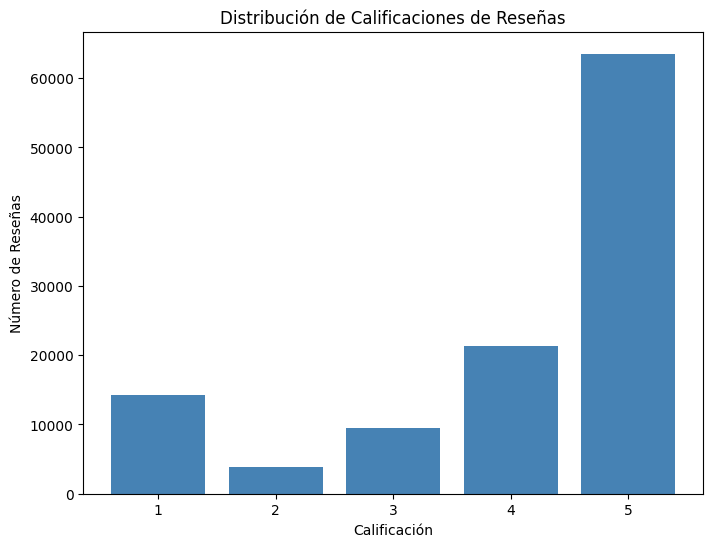

In [50]:

bar_chart(
    df_analysis['review_score'].value_counts().to_dict(),
    title='Distribución de Calificaciones de Reseñas',
    xlabel='Calificación',
    ylabel='Número de Reseñas'
)

In [51]:
def calculate_stats_per_row (data, column):
    data[column] = data[column].fillna('')
    
    # Cantidad de caracteres
    data['char_count'] = data[column].str.len()
    
    # Cantidad de palabras
    data['word_count'] = data[column].apply(lambda x: len(x.split()))
    
    # Cantidad de oraciones (aproximado por puntos, signos de exclamación e interrogación)
    data['sentence_count'] = data[column].apply(
        lambda x: max(1, len(re.split(r'[.!?]+', x.strip())) - 1)
    )
    
    # Longitud promedio de palabras
    data['avg_word_length'] = data[column].apply(
        lambda x: sum(len(word) for word in x.split()) / len(x.split()) if x.split() else 0
    )
    
    # Palabras por oración
    data['words_per_sentence'] = data['word_count'] / data['sentence_count']
    
    # Palabras únicas
    data['unique_words_count'] = data[column].apply(
        lambda x: len(set(x.lower().split()))
    )
    # Signos de exclamación
    data['exclamation_count'] = data[column].str.count('!')
    
    # Signos de interrogación
    data['question_count'] = data[column].str.count(r'\?')
    
    # Comas
    data['comma_count'] = data[column].str.count(',')
    
    # Puntos
    data['period_count'] = data[column].str.count(r'\.')
    return data

df_maestro['full_text'] = df_maestro['review_comment_title'].fillna('') + '' + df_maestro['review_comment_message'].fillna('')

calculate_stats_per_row(df_maestro, 'full_text')


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,customer_id,order_status,order_purchase_timestamp,...,char_count,word_count,sentence_count,avg_word_length,words_per_sentence,unique_words_count,exclamation_count,question_count,comma_count,period_count
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59,41dcb106f807e993532d446263290104,delivered,2018-01-11 15:30:49,...,0,0,1,0.000000,0.0,0,0,0,0,0
1,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59,41dcb106f807e993532d446263290104,delivered,2018-01-11 15:30:49,...,0,0,1,0.000000,0.0,0,0,0,0,0
2,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13,8a2e7ef9053dea531e4dc76bd6d853e6,delivered,2018-02-28 12:25:19,...,0,0,1,0.000000,0.0,0,0,0,0,0
3,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24,e226dfed6544df5b7b87a48208690feb,delivered,2018-02-03 09:56:22,...,0,0,1,0.000000,0.0,0,0,0,0,0
4,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06,de6dff97e5f1ba84a3cd9a3bc97df5f6,delivered,2017-04-09 17:41:13,...,37,6,1,5.333333,6.0,6,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112367,574ed12dd733e5fa530cfd4bbf39d7c9,2a8c23fee101d4d5662fa670396eb8da,5,NaN,NaN,2018-07-07 00:00:00,2018-07-14 17:18:30,d8c466a3e7c4cda36cd4ae7d577f44f4,delivered,2018-06-27 17:31:29,...,0,0,1,0.000000,0.0,0,0,0,0,0
112368,f3897127253a9592a73be9bdfdf4ed7a,22ec9f0669f784db00fa86d035cf8602,5,NaN,NaN,2017-12-09 00:00:00,2017-12-11 20:06:42,d0d7086dea6fcf42b9b690b9f3745c58,delivered,2017-12-03 21:45:23,...,0,0,1,0.000000,0.0,0,0,0,0,0
112369,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,NaN,"Excelente mochila, entrega super rápida. Super...",2018-03-22 00:00:00,2018-03-23 09:10:43,fcc7b1caafe3b77fd587bab964c4d1fb,delivered,2018-03-18 09:52:19,...,67,9,2,6.555556,4.5,8,1,0,1,1
112370,1adeb9d84d72fe4e337617733eb85149,7725825d039fc1f0ceb7635e3f7d9206,4,NaN,NaN,2018-07-01 00:00:00,2018-07-02 12:59:13,3aa00401736823c73e9fe8683328fa6b,delivered,2018-06-22 16:47:28,...,0,0,1,0.000000,0.0,0,0,0,0,0


In [52]:
df_maestro.columns

Index(['review_id', 'order_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp', 'customer_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'order_item_id', 'product_id',
       'seller_id', 'shipping_limit_date', 'price', 'freight_value',
       'delivery_delta_days', 'seller_dispatch_days', 'carrier_transit_days',
       'full_text', 'payment_installments', 'payment_value', 'payment_type',
       'customer_zip_code_prefix', 'customer_city', 'customer_state',
       'seller_zip_code_prefix', 'seller_city', 'seller_state',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'geo_lat_customer', 'geo_lng_customer',

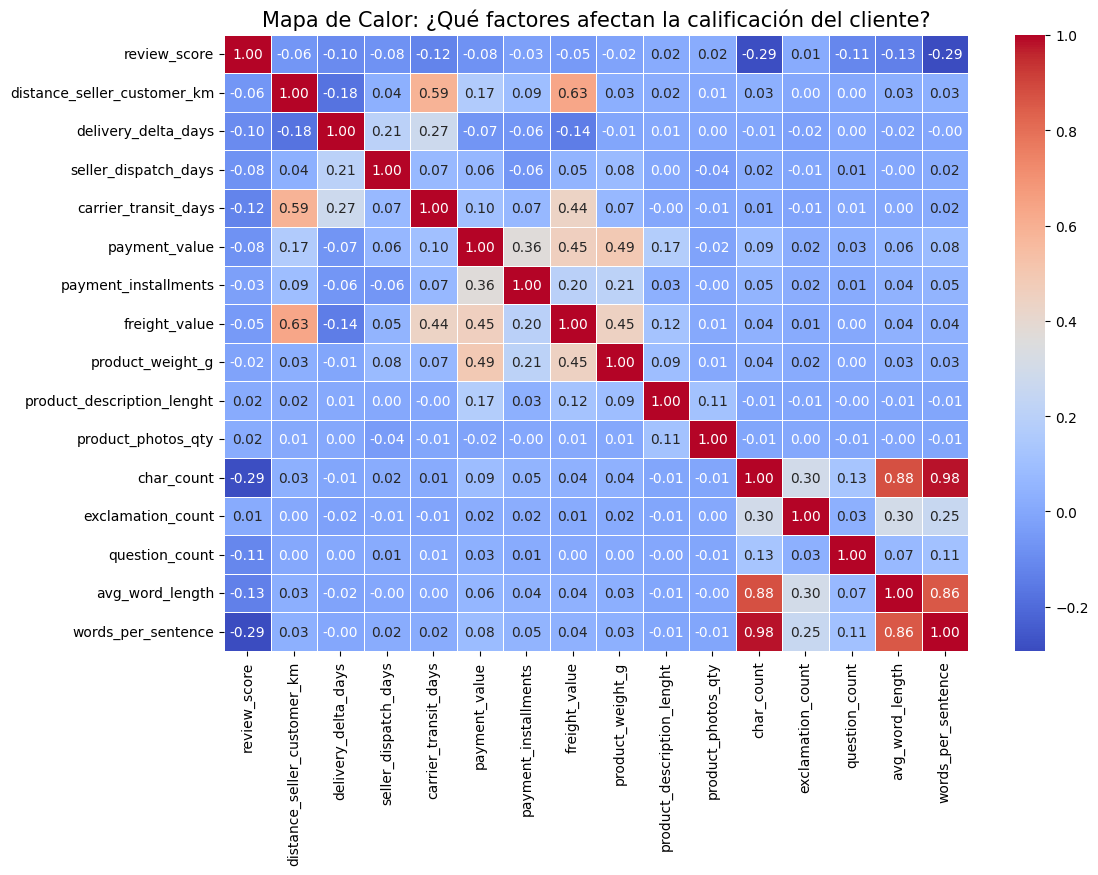

In [74]:
cols_para_correlacion = [
    'review_score',                 # Calificación del cliente (variable objetivo)
    'distance_seller_customer_km',  # Distancia entre vendedor y cliente (distancia larga = más riesgo)
    'delivery_delta_days',          # Tiempo entre fecha estimada y fecha real de entrega (logística deficiente = más riesgo)
    'seller_dispatch_days',         # Tiempo entre compra y entrega al transportista (logística deficiente = más riesgo)
    'carrier_transit_days',         # Tiempo total en tránsito (logística deficiente = más riesgo)
    'payment_value',                # Valor total de la transacción
    'payment_installments',         # Número de cuotas
    'freight_value',                # Costo del envío
    'product_weight_g',             # Peso (logística pesada = más riesgo)
    'product_description_lenght',   # Calidad de la descripción del producto (descripciones pobres = más riesgo)
    'product_photos_qty',           # Cantidad de fotos del producto (falta de fotos puede indicar problemas)
    'char_count',                   # Longitud del comentario
    'exclamation_count',            # Intensidad emocional del comentario
    'question_count',               # Curiosidad o insatisfacción (más signos de interrogación = más riesgo)
    'avg_word_length',              # Complejidad del lenguaje (lenguaje muy simple o muy complejo puede indicar problemas)
    'words_per_sentence'            # Complejidad del comentario (comentarios muy simples o muy complejos pueden indicar problemas)
]

# 2. Calculamos la matriz de correlación
corr_matrix = df_maestro[cols_para_correlacion].corr(method='spearman')

# 3. Graficamos
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Mapa de Calor: ¿Qué factores afectan la calificación del cliente?', fontsize=15)
plt.savefig('correlation_heatmap.png')
plt.show()

/tmp/ipykernel_15795/3251416687.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=null_data.index, y=null_data.values, palette='mako')


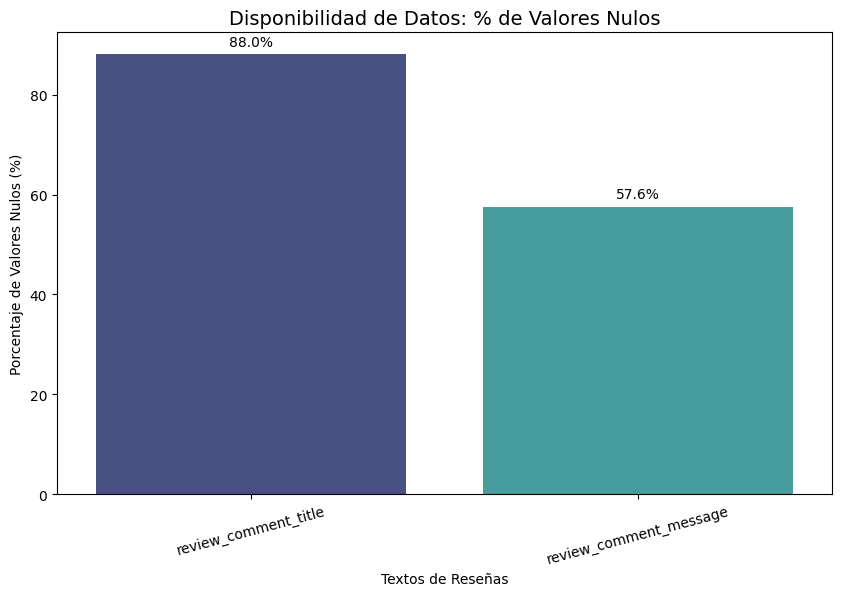

In [72]:
# Seleccionamos las columnas clave para mostrar la ausencia de datos
cols_interes = ['review_comment_title', 'review_comment_message']
null_data = df_maestro[cols_interes].isnull().mean() * 100

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=null_data.index, y=null_data.values, palette='mako')
plt.title('Disponibilidad de Datos: % de Valores Nulos', fontsize=14)
plt.ylabel('Porcentaje de Valores Nulos (%)')
plt.xlabel('Textos de Reseñas')

# Añadir etiquetas de porcentaje sobre las barras
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 9), textcoords='offset points')

plt.xticks(rotation=15)
plt.savefig('null_distribution.png')
plt.show()

/tmp/ipykernel_15795/1657581918.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_maestro, x='review_score', palette='RdYlGn', order=[1, 2, 3, 4, 5])


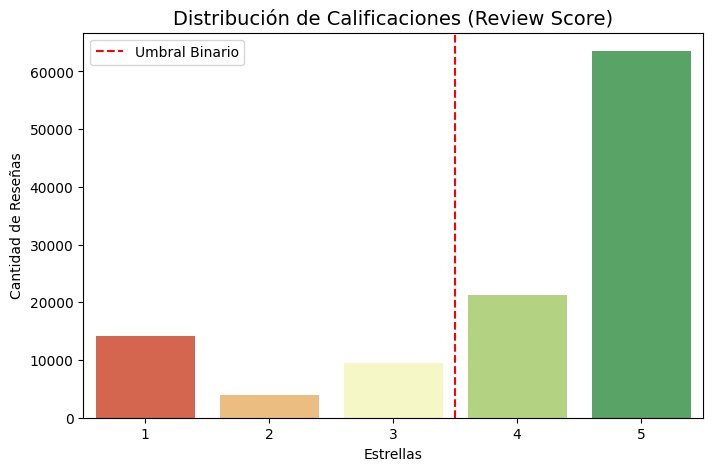

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df_maestro, x='review_score', palette='RdYlGn', order=[1, 2, 3, 4, 5])
plt.title('Distribución de Calificaciones (Review Score)', fontsize=14)
plt.xlabel('Estrellas')
plt.ylabel('Cantidad de Reseñas')
plt.axvline(x=2.5, color='red', linestyle='--', label='Umbral Binario')
plt.legend()
plt.savefig('class_distribution.png')
plt.show()

/tmp/ipykernel_15795/4243747017.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_plot, x='review_score', y='delivery_delta_days', palette='RdYlGn')


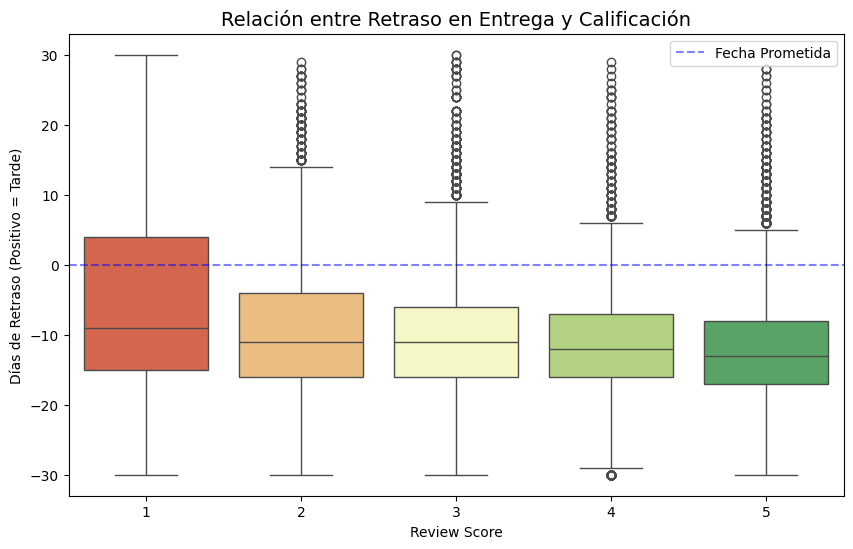

In [73]:
# Filtramos valores extremos de fechas para que el gráfico sea legible
df_plot = df_maestro[df_maestro['delivery_delta_days'].between(-30, 30)]

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_plot, x='review_score', y='delivery_delta_days', palette='RdYlGn')
plt.axhline(y=0, color='blue', linestyle='--', alpha=0.5, label='Fecha Prometida')
plt.title('Relación entre Retraso en Entrega y Calificación', fontsize=14)
plt.ylabel('Días de Retraso (Positivo = Tarde)')
plt.xlabel('Review Score')
plt.legend()

plt.savefig('delay_vs_score.png')
plt.show()